In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
a, b, c = 170, 170, 250
epsilon = 1e-2

n_zs = 20
dist = c / (1.76*n_zs)
zs = np.linspace(-c+dist/2, c-dist/2, n_zs)

thetas = np.arcsin(zs/c)
av_rhos = (a + b) * np.cos(thetas) / 2
n_cells = np.ceil(av_rhos/dist).astype(np.int)

phis = np.concatenate(
    [np.linspace(-np.pi, np.pi, nc, endpoint=False)
     + (np.pi/nc) * (i%2) for i, nc in enumerate(n_cells)])
zs = np.concatenate(
    [z * np.ones(nc) for z, nc in zip(zs, n_cells)])
thetas = np.concatenate(
    [theta * np.ones(nc) for theta, nc in zip(thetas, n_cells)])

xs = a * np.cos(thetas) * np.cos(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
ys = b * np.cos(thetas) * np.sin(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
zs +=  np.random.normal(scale=epsilon, size=thetas.shape)
print(zs.shape)


(376,)


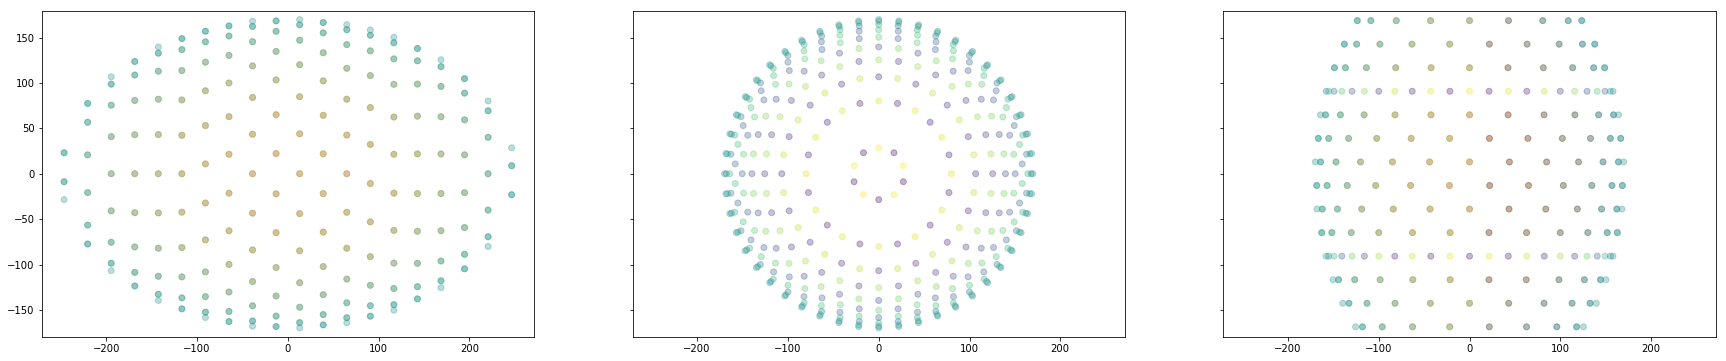

In [3]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)


fig.set_size_inches(30, 6)
axes[0].scatter(zs, xs, c=ys,
                alpha=0.3, cmap='viridis')
axes[1].scatter(ys, xs, c=zs,
                alpha=0.3, cmap='viridis')
axes[2].scatter(ys, zs, c=xs,
                alpha=0.3, cmap='viridis')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

In [4]:
from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

In [5]:
def get_subeptm(cond, coords):
    
    
    f_ids = np.arange(ys.size)
    points = np.vstack([xs[cond],
                        ys[cond],
                        zs[cond]]).T

    voro = Voronoi(points[:, coords[:2]])
    datasets = from_2d_voronoi(voro)

    eptm = Epithelium('3D_test', datasets,
                      config.geometry.spherical_sheet())
    eptm.face_df['z'] = points[:, coords[2]]
    eptm.face_df['f_ids'] = f_ids[cond]
    eptm.edge_df['f_ids'] = eptm.upcast_face(eptm.face_df['f_ids'])
    eptm.sanitize()
    eptm.edge_df['z'] = eptm.upcast_face(eptm.face_df['z'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['z'].mean()
    coords = [list('xyz')[c] for c in coords]
    eptm.vert_df[['x', 'y', 'z']] = eptm.vert_df[coords]
    SheetGeometry.update_all(eptm)
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_fids'] = eptm.edge_df.loc[
        eptm.edge_df['opposite'].values,
        'f_ids'].values.astype(np.int)
    
    for c in 'xyz':
        eptm.edge_df['s'+c] = eptm.upcast_srce(eptm.vert_df[c]) 
        eptm.edge_df['t'+c] = eptm.upcast_trgt(eptm.vert_df[c]) 
        
    return eptm

In [94]:
eptm_zpos = get_subeptm(zs>=0, [0, 1, 2])
eptm_zneg = get_subeptm(zs<=0, [0, 1, 2])
eptm_ypos = get_subeptm(ys>=0, [0, 2, 1])
eptm_yneg = get_subeptm(ys<=0, [0, 2, 1])
eptm_xpos = get_subeptm(xs>=0, [2, 1, 0])
eptm_xneg = get_subeptm(xs<=0, [2, 1, 0])



In [95]:
edge_df = pd.concat([eptm_zpos.edge_df.dropna(),
                     eptm_zneg.edge_df.dropna(),
                     eptm_ypos.edge_df.dropna(),
                     eptm_yneg.edge_df.dropna(),
                     eptm_xpos.edge_df.dropna(),
                     eptm_xneg.edge_df.dropna()],
                    ignore_index=True)

In [96]:
dups = edge_df[edge_df.duplicated(['f_ids', 'opp_fids'])].index

In [97]:
srce_pos = edge_df.groupby(['f_ids', 'opp_fids'])[['sx', 'sy', 'sz']].mean()
trgt_pos = edge_df.groupby(['f_ids', 'opp_fids'])[['tx', 'ty', 'tz']].mean()


In [98]:
srce_pos_tuple = edge_df.groupby(['f_ids', 'opp_fids'])['srce'].apply(frozenset)

(-200, 200)

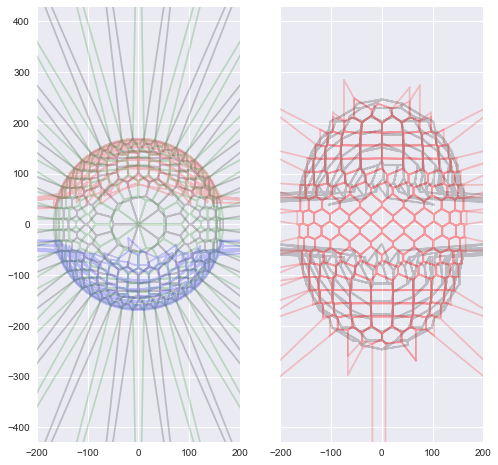

In [99]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
quick_edge_draw(eptm_zpos, ax=ax[0],
                c='k', alpha=0.2)
quick_edge_draw(eptm_zneg, ax=ax[1],
                c='k', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_ypos, ax=ax[0],
                c='r', alpha=0.2)
quick_edge_draw(eptm_yneg, ax=ax[1],
                c='r', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_zneg, ax=ax[0],
                c='g', alpha=0.2)
quick_edge_draw(eptm_zpos, ax=ax[1],
                c='k', alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_yneg, ax=ax[0],
                c='b', alpha=0.2)
quick_edge_draw(eptm_ypos, ax=ax[1],
                c='r', alpha=0.2, coords=['x', 'z'])


fig.set_size_inches((8,8))
ax[0].set_aspect('equal')
ax[0].set_xlim(-200, 200)

ax[0].set_ylim(-200, 200)
ax[1].set_xlim(-200, 200)

In [18]:
rdr, scene = view_3js(eptm_xneg)
rdr

In [102]:
from tyssue.draw.threejs_draw import edge_lines
import pythreejs as py3js

import seaborn as sns

import matplotlib as mpl

In [103]:
eptms = [eptm_xneg, eptm_xpos,
         eptm_yneg, eptm_ypos,
         eptm_zneg, eptm_zpos,]
colors = [mpl.colors.rgb2hex(c) for c
          in sns.color_palette("Set1", n_colors=8,
                               desat=.5)]

lines = [edge_lines(eptm, list('xyz'), vert={'color':color})
         for eptm, color in zip(eptms, colors)]

children = [py3js.DirectionalLight(color='#ccaabb',
                                   position=[0, 5, 0]),
            py3js.AmbientLight(color='#cccccc')]
children.extend(lines)

scene = py3js.Scene(children=children)
cam = py3js.PerspectiveCamera(position=[0, 5, 5])
renderer = py3js.Renderer(camera=cam,
                          scene=scene,
                          controls=[py3js.OrbitControls(controlling=cam)])

In [104]:
renderer

In [105]:

def get_dist_to_center(eptm):
    
    center = eptm.vert_df[eptm.coords].mean(axis=0)
    for c in eptm.coords:
        eptm.vert_df['r'+c] = eptm.vert_df[c] - center[c]
    eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[['rx', 'ry', 'rz']],
                                         axis=1)
    

In [106]:
eptm.vert_df[['rx', 'ry', 'rz']].head()

,rx,ry,rz
vert,,,
0,25.185043,-5.510772,240.726175
1,27.914509,-19.087846,-234.223957
2,48.646858,61.497233,-260.199867
3,-21.442584,-48.116655,149.160492
4,35.916897,49.201035,258.883983


In [107]:
for eptm in eptms:
    get_dist_to_center(eptm)

In [108]:
np.abs(eptm.vert_df['rho']).min()

122.71846686648654

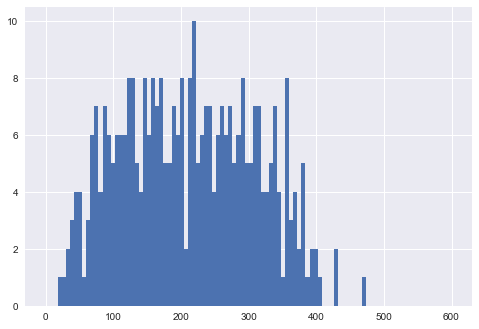

In [112]:
H = plt.hist(eptm_xneg.vert_df.rho, range=[0, 600], bins=100)

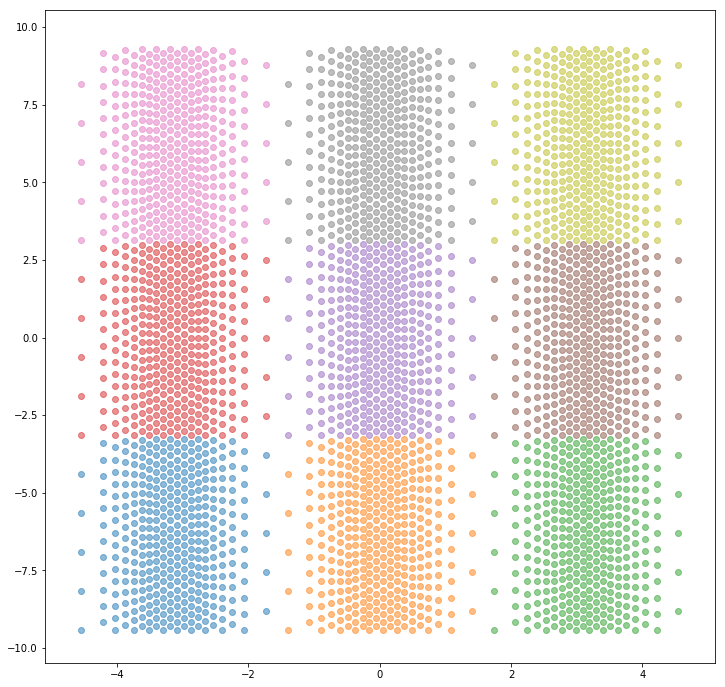

In [32]:
fig, ax = plt.subplots()
theta_shifts = [-np.pi, 0, np.pi]
phi_shifts = [-2*np.pi, 0, 2*np.pi]
theta_shifts, phi_shifts = np.meshgrid(theta_shifts,
                                       phi_shifts)
for dtheta, dphi in zip(theta_shifts.ravel(),
                        phi_shifts.ravel()):

    ax.scatter(thetas+dtheta, phis+dphi, alpha=0.5)

fig.set_size_inches(12, 12)

In [35]:
theta_shifts.shape


(3, 3)

In [33]:
pbc_thetas = np.concatenate([thetas + shift for shift in theta_shifts.ravel()])
pbc_phis = np.concatenate([phis + shift for shift in phi_shifts.ravel()])
pbc_voro = Voronoi(np.vstack([pbc_thetas, pbc_phis]).T)

In [38]:
pbc_dsets = from_2d_voronoi(pbc_voro)

In [39]:
pbc_dsets['face'].shape

(3384, 6)

In [40]:
phis.size

376

In [41]:
pbc_dsets['face']['f_ids'] = np.concatenate([np.arange(phis.size),]*9)

In [42]:

pbc_eptm = Epithelium('theta_phi', pbc_dsets, config.geometry.flat_sheet())

In [43]:
from tyssue import PlanarGeometry
pbc_eptm.sanitize()

In [44]:
PlanarGeometry.update_all(pbc_eptm)

In [45]:
pbc_eptm.edge_df['sx'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['x'])
pbc_eptm.edge_df['sy'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['y'])

border = ((pbc_eptm.edge_df['sx'] < -np.pi) |
          (pbc_eptm.edge_df['sx'] > np.pi) |
          (pbc_eptm.edge_df['sy'] < -2*np.pi) |
          (pbc_eptm.edge_df['sy'] > 2*np.pi))

to_remove = pbc_eptm.edge_df[border].index
pbc_eptm.remove(to_remove)
#pbc_eptm.reset_index

(<matplotlib.figure.Figure at 0x7fc6889fc320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc6889f9ac8>)

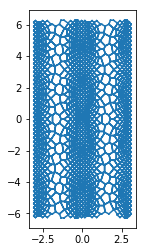

In [46]:
quick_edge_draw(pbc_eptm)

In [47]:
from tyssue.core.objects import get_opposite

In [48]:
pbc_eptm.vert_df['theta'] = pbc_eptm.vert_df['x']
pbc_eptm.vert_df['phi'] = pbc_eptm.vert_df['y']
pbc_eptm.vert_df['x'] = a * np.cos(pbc_eptm.vert_df['theta']) * np.cos(pbc_eptm.vert_df['phi'])
pbc_eptm.vert_df['y'] = b * np.cos(pbc_eptm.vert_df['theta']) * np.sin(pbc_eptm.vert_df['phi'])
pbc_eptm.vert_df['z'] = c * np.sin(pbc_eptm.vert_df['theta'])

In [52]:
render, scene = view_3js(pbc_eptm)

render

In [54]:
pbc_eptm.edge_df['f_ids'] = pbc_eptm.upcast_face(pbc_eptm.face_df.f_ids)


In [55]:
from tyssue.utils import data_at_opposite

In [58]:
pbc_eptm.edge_df['opposite'] = get_opposite(pbc_eptm.edge_df)
pbc_eptm.edge_df['opp_f_ids'] = data_at_opposite(pbc_eptm, pbc_eptm.edge_df['f_ids'])

In [80]:
pbc_eptm.vert_df['nv'] = np.NaN
    
iso_srce = pbc_eptm.edge_df.groupby(['f_ids', 'opp_f_ids'])['srce'].apply(list).reset_index()

In [83]:
pbc_eptm.vert_df['nv'] = -1

for i, vs in iso_srce.iterrows():
    pbc_eptm.vert_df.loc[vs['srce'], 'nv'] = i

In [84]:
pbc_eptm.vert_df.nv

vert
0       2220
1       2217
2       2197
3       2212
4         78
5       2169
6       2218
7       2175
8       2178
9       2185
10      2207
11      2175
12      2076
13      2156
14      2165
15      2229
16      2226
17      2227
18      2230
19      2231
20      2170
21      2080
22      2081
23      2206
24      2199
25       108
26      2134
27      2201
28      2136
29      1337
        ... 
2938      -1
2939      -1
2940    1466
2941    1603
2942    1611
2943    1609
2944    1473
2945    1981
2946    1982
2947    1747
2948    1749
2949    1871
2950      -1
2951      -1
2952    1748
2953    1876
2954    1471
2955      -1
2956      -1
2957    1610
2958      -1
2959    1464
2960    1329
2961    1472
2962      -1
2963    1334
2964      -1
2965      -1
2966      -1
2967      -1
Name: nv, dtype: int64